Using DeepAR from gluonts which published by Amazon.
The data was got from www.baostock.com.
The code is reference of https://github.com/samemelody/gluon-ts/blob/master/examples/COV19-forecast.ipynb
NOTE: this notebook is for illustration purposes only.

In [3]:

import pprint
from functools import partial
import baostock as bs
import pandas as pd

from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from pathlib import Path
from gluonts.model.predictor import Predictor
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
import matplotlib.pyplot as plt
import json
#tqdm.autonotebook.tqdm
from tqdm.autonotebook import tqdm

ModuleNotFoundError: No module named 'baostock'

Get the data from baostock.com using volume(jiaoyishuliang) and turn (zhuanshoulv)as dynamic_feat

In [8]:
def mygetstockdata(code):
    
   # print('login respond error_code:'+lg.error_code)
   # print('login respond  error_msg:'+lg.error_msg)
    rs = bs.query_history_k_data_plus(code,
        "date,close,volume,turn",
        start_date='2018-01-01', 
        frequency="d", adjustflag="2") #frequency="d"取日k线，adjustflag="3"默认不复权
   
    return rs.get_data()

Randomly choose 10 stock codes to test the Deepar.

In [9]:

liststock =['sh.000001','sz.399001','sz.002068','sz.300324','sh.600754','sz.300439','sh.600862','sh.603991','sh.600081','sz.300026']
prediction_length = 20
#liststock = ['sz.300462','sz.300789']
listtrandic = []
listtestdic = []
lg = bs.login()
for ite in liststock:
    dd = mygetstockdata(ite)
    trandic = {"start":dd.date[0],"target":list(dd.close),"cat":int(ite.split('.')[1]),"dynamic_feat":[list(dd.volume),list(dd.turn)]}
    testdic = {"start":dd.date[0],
                   "target":(dd.close)[:-prediction_length],
                   "cat":int(ite.split('.')[1]),
                   "dynamic_feat":[(dd.volume)[:-prediction_length],(dd.turn)[:-prediction_length]]}
    #strjon = json.dumps(dic)
    listtrandic.append(trandic)
    listtestdic.append(testdic)
bs.logout()

traindata = ListDataset(
    listtrandic,
    freq = "1d"
)

testdata = ListDataset(
    listtestdic,
    freq = "1d"
)

login success!
logout success!


## Training

In [14]:
#prediction_length = 30
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=60,
    freq="1d",
    trainer=Trainer(ctx="cpu",
                    epochs=100,#30
                    learning_rate=1e-2,
                    num_batches_per_epoch=300, #100
                   )
)
predictor = estimator.train(traindata)

#predictor.serialize(Path("./tmp/"))


100%|██████████| 300/300 [00:29<00:00, 10.26it/s, epoch=100/100, avg_epoch_loss=0.329]


## Predictor

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm.autonotebook import tqdm
forecast_it, ts_it = make_evaluation_predictions(
    dataset=testdata,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(testdata)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(testdata)))

## Evaluate
I don't understand the result of evaluate.Just copy from the gluonts example.

In [16]:
from gluonts.evaluation import Evaluator
import numpy as np

class CustomEvaluator(Evaluator):

    def get_metrics_per_ts(self, time_series, forecast):
        successive_diff = np.diff(time_series.values.reshape(len(time_series)))
        successive_diff = successive_diff ** 2
        successive_diff = successive_diff[:-prediction_length]
        denom = np.mean(successive_diff)
        pred_values = forecast.samples.mean(axis=0)
        true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
        num = np.mean((pred_values - true_values) ** 2)
        rmsse = num / denom
        metrics = super().get_metrics_per_ts(time_series, forecast)
        metrics["RMSSE"] = rmsse
        return metrics

    def get_aggregate_metrics(self, metric_per_ts):
        wrmsse = metric_per_ts["RMSSE"].mean()
        agg_metric, _ = super().get_aggregate_metrics(metric_per_ts)
        agg_metric["MRMSSE"] = wrmsse
        return agg_metric, metric_per_ts


evaluator = CustomEvaluator(quantiles=[0.5, 0.67, 0.90, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(testdata))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 148.39it/s]


{
    "MSE": 3619.7736423171873,
    "abs_error": 3583.1477556228638,
    "abs_target_sum": 281853.9563674927,
    "abs_target_mean": 1409.2697818374636,
    "seasonal_error": 13.762038205442645,
    "MASE": 1.000369953479075,
    "MAPE": 0.014337905701037759,
    "sMAPE": 0.014506815388753327,
    "OWA": NaN,
    "MSIS": 12.652102304412496,
    "QuantileLoss[0.5]": 3583.1477556228638,
    "Coverage[0.5]": 0.42000000000000004,
    "QuantileLoss[0.67]": 3693.3699809980394,
    "Coverage[0.67]": 0.65,
    "QuantileLoss[0.9]": 2276.760109806061,
    "Coverage[0.9]": 0.8699999999999999,
    "QuantileLoss[0.99]": 371.8724076271058,
    "Coverage[0.99]": 0.9650000000000001,
    "RMSE": 60.164554700564246,
    "NRMSE": 0.042692006510009206,
    "ND": 0.012712781476627596,
    "wQuantileLoss[0.5]": 0.012712781476627596,
    "wQuantileLoss[0.67]": 0.013103842956820067,
    "wQuantileLoss[0.9]": 0.008077800784309475,
    "wQuantileLoss[0.99]": 0.001319379768230904,
    "mean_wQuantileLoss": 0.00

## PLOT
The image of the predicor result ,also copy the code from the code .
I just start learning the machine learning few months , so just copy.
But the result is very good.Exceeding my expectation.

Plotting time series predictions ...


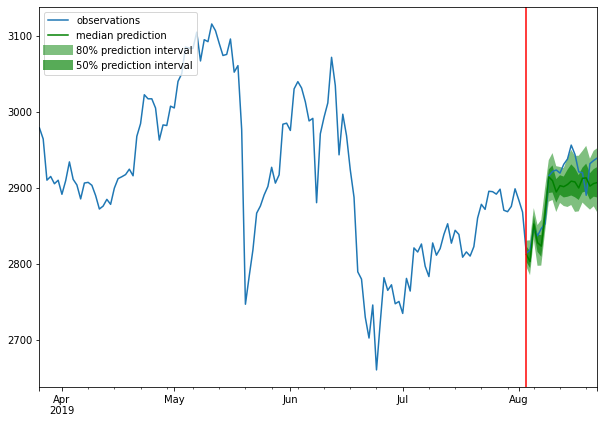

<Figure size 432x288 with 0 Axes>

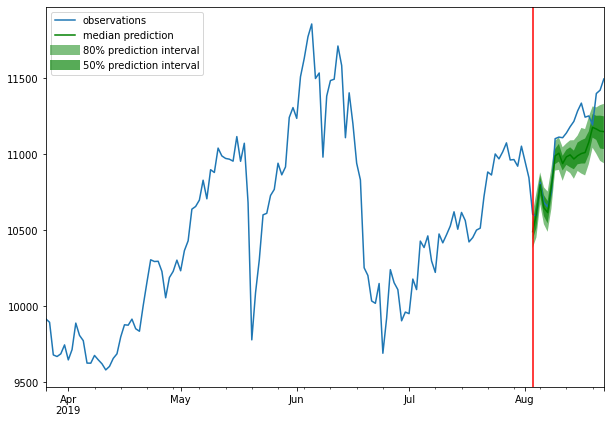

<Figure size 432x288 with 0 Axes>

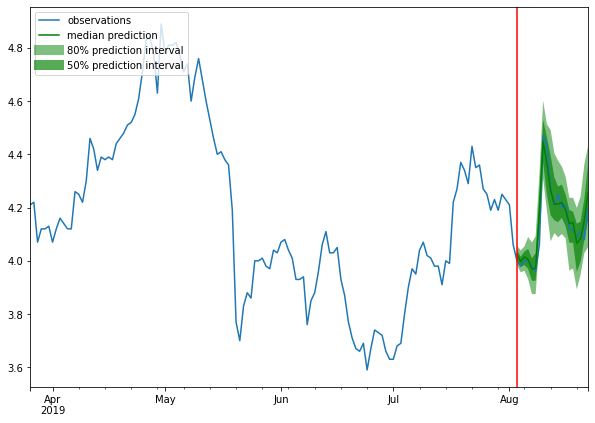

<Figure size 432x288 with 0 Axes>

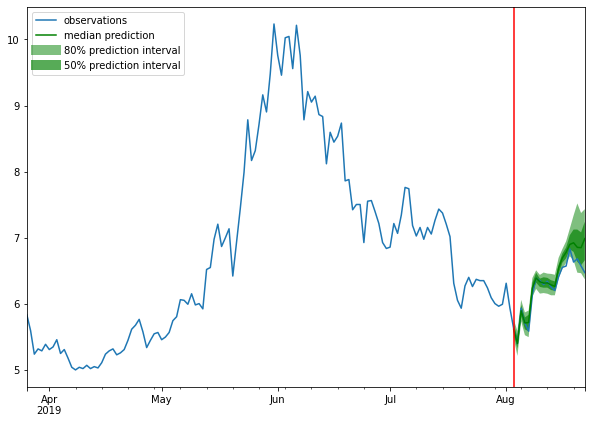

<Figure size 432x288 with 0 Axes>

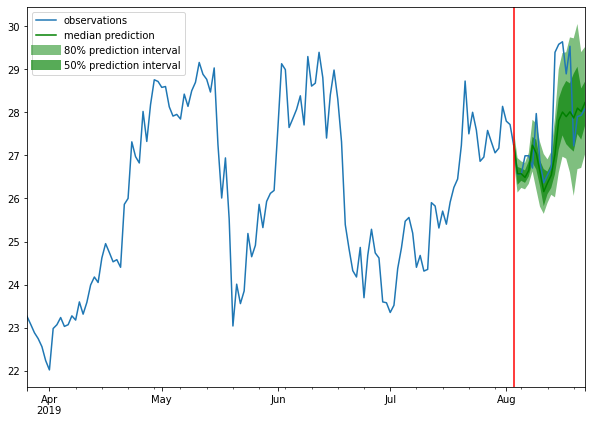

<Figure size 432x288 with 0 Axes>

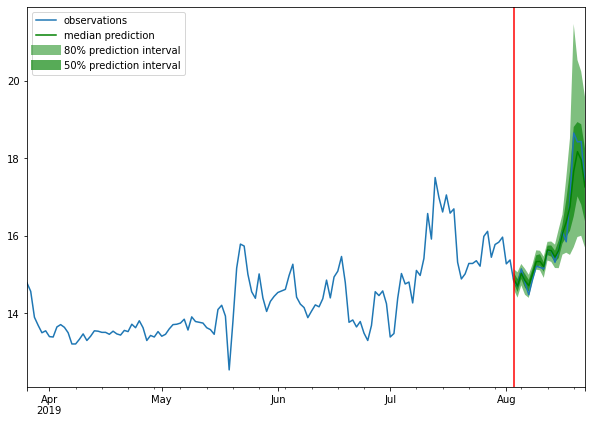

<Figure size 432x288 with 0 Axes>

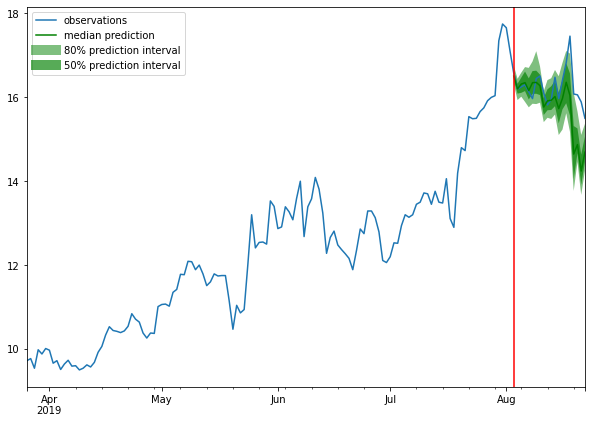

<Figure size 432x288 with 0 Axes>

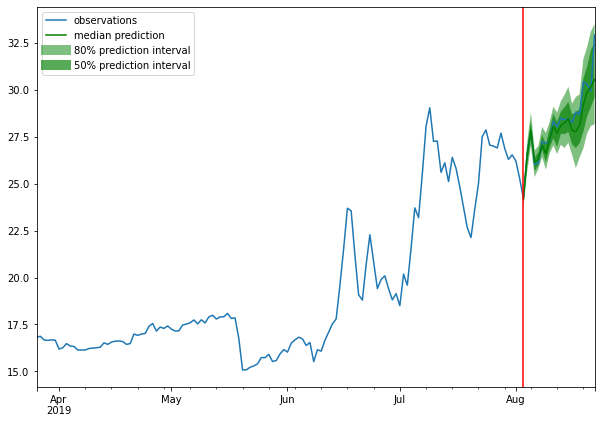

<Figure size 432x288 with 0 Axes>

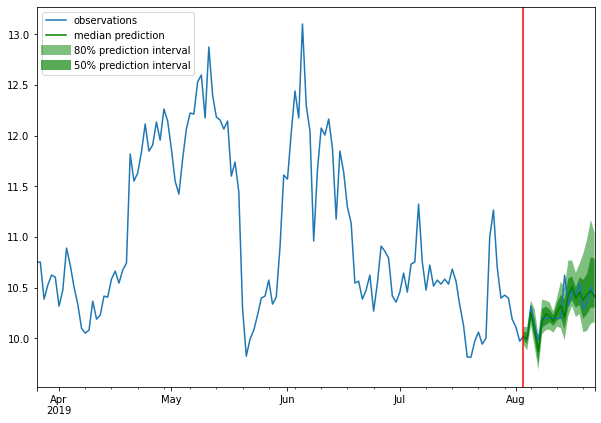

<Figure size 432x288 with 0 Axes>

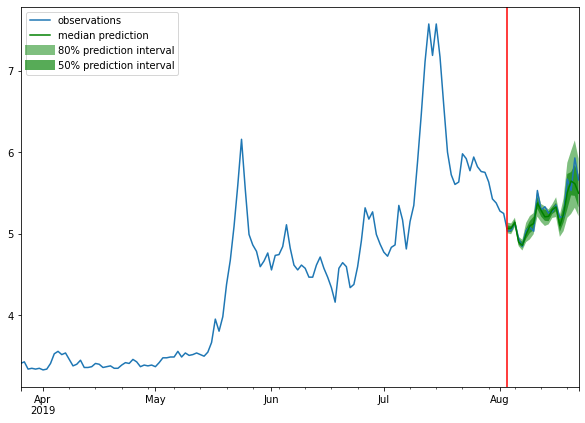

<Figure size 432x288 with 0 Axes>

In [17]:
import os

plot_log_path = "./plots/"
directory = os.path.dirname(plot_log_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    

def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 150
    prediction_intervals = (50, 80)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(10)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)

